# Food101 - Data Ingestion Pipeline

This notebook loads Food101 image data from h5 files stored in Databricks volumes and writes them to a Delta table.

**Data Sources:**
* Training images and labels from `food101_train.h5`
* Validation images and labels from `food101_validation.h5`

**Output:**
* Bronze Delta table containing all images with labels in the schema:
  - split: string (train/validation)
  - label_id: integer
  - label: string
  - image_bytes: binary


## Setup and Configuration


In [0]:
# Install required packages
%pip install h5py==3.11.0
dbutils.library.restartPython()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/5.4 MB ? eta -:--:--
   ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/5.4 MB 8.0 MB/s eta 0:00:01
   ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.7/5.4 MB 10.0 MB/s eta 0:00:01
   ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/5.4 MB 11.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/5.4 MB 13.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━ 2.8/5.4 MB 16.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 3.8/5.4 MB 18.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 5.2/5.4 MB 21.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 20.6 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Configuration
CATALOG = "jdub_demo_aws"
SCHEMA = "food101"
TABLE = "bronze_low_res"

# Volume paths to h5 files
TRAIN_H5_PATH = "/Volumes/jdub_demo_aws/food101/food101_data/64x64/food101_train.h5"
VAL_H5_PATH = "/Volumes/jdub_demo_aws/food101/food101_data/64x64/food101_validation.h5"

# Full table name
FULL_TABLE_NAME = f"{CATALOG}.{SCHEMA}.{TABLE}"

print(f"Target table: {FULL_TABLE_NAME}")
print(f"Training data: {TRAIN_H5_PATH}")
print(f"Validation data: {VAL_H5_PATH}")


Target table: jdub_demo_aws.food101.bronze_low_res
Training data: /Volumes/jdub_demo_aws/food101/food101_data/64x64/food101_train.h5
Validation data: /Volumes/jdub_demo_aws/food101/food101_data/64x64/food101_validation.h5


## Load Data from H5 Files

We'll load the Food101 images and labels from the h5 files stored in Databricks volumes. Each h5 file contains:
- `images`: array of image data
- `labels`: array of integer label IDs
- `label_names`: array of label names (class names)


In [0]:
# First, let's inspect the h5 file structure to see what keys are available
import h5py

def inspect_h5_file(h5_path):
    """Inspect the structure of an h5 file"""
    print(f"\nInspecting: {h5_path}")
    print("=" * 60)
    with h5py.File(h5_path, 'r') as f:
        print("Available keys:")
        for key in f.keys():
            print(f"  - {key}: {f[key].shape if hasattr(f[key], 'shape') else 'N/A'}")
            if hasattr(f[key], 'dtype'):
                print(f"    dtype: {f[key].dtype}")
    print("=" * 60)

# Inspect both files
inspect_h5_file(TRAIN_H5_PATH)
inspect_h5_file(VAL_H5_PATH)


Running cells with '.venv (Python 3.11.11)' requires the ipykernel package.

Install 'ipykernel' into the Python environment. 

Command: '/Users/jonathan.whiteley/Desktop/Databricks_Apps/projects/food101_conformal_prod/.venv/bin/python -m pip install ipykernel -U --force-reinstall'

In [0]:
import h5py
import numpy as np
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BinaryType
import io
from PIL import Image

def load_h5_data(h5_path, split_name):
    """
    Load images and labels from h5 file and convert to list of Rows.
    
    Args:
        h5_path: Path to h5 file in Databricks volume
        split_name: Name of the split (e.g., 'train' or 'validation')
    
    Returns:
        List of Row objects with schema: split, label_id, label, image_bytes
    """
    print(f"Loading {split_name} data from {h5_path}...")
    
    with h5py.File(h5_path, 'r') as f:
        # Load data from h5 file based on observed structure
        images = f['images'][:]
        categories = f['category'][:]  # One-hot encoded labels
        category_names = f['category_names'][:]
        
        # Decode category names (they're stored as byte strings)
        label_names = [name.decode('utf-8') if isinstance(name, bytes) else name 
                      for name in category_names]
        
        # Convert one-hot encoded categories to label IDs
        label_ids = np.argmax(categories, axis=1)
        
        print(f"  - Images shape: {images.shape}")
        print(f"  - Categories shape: {categories.shape}")
        print(f"  - Number of classes: {len(label_names)}")
        print(f"  - Label distribution: {np.bincount(label_ids)[:5]}... (showing first 5)")
        
        # Convert to list of Rows
        rows = []
        for i in range(len(images)):
            # Convert image to bytes (JPEG format)
            img = Image.fromarray(images[i])
            img_bytes = io.BytesIO()
            img.save(img_bytes, format='JPEG')
            
            # Get label info
            label_id = int(label_ids[i])
            label_name = label_names[label_id]
            
            # Create row
            row = Row(
                split=split_name,
                label_id=label_id,
                label=label_name,
                image_bytes=img_bytes.getvalue()
            )
            rows.append(row)
        
        print(f"  - Successfully loaded {len(rows)} records")
        return rows

# Load training data
train_rows = load_h5_data(TRAIN_H5_PATH, "train")

# Load validation data
val_rows = load_h5_data(VAL_H5_PATH, "validation")


Loading train data from /Volumes/jdub_demo_aws/food101/food101_data/64x64/food101_train.h5...
  - Images shape: (10099, 64, 64, 3)
  - Categories shape: (10099, 101)
  - Number of classes: 101
  - Label distribution: [113 102  89  99 103]... (showing first 5)
  - Successfully loaded 10099 records
Loading validation data from /Volumes/jdub_demo_aws/food101/food101_data/64x64/food101_validation.h5...
  - Images shape: (1000, 64, 64, 3)
  - Categories shape: (1000, 101)
  - Number of classes: 101
  - Label distribution: [ 8 10 11 14 10]... (showing first 5)
  - Successfully loaded 1000 records


## Create DataFrame and Write to Delta Table

Now we'll combine both datasets and write to our bronze Delta table.


In [0]:
# Define schema
schema = StructType([
    StructField("split", StringType(), True),
    StructField("label_id", IntegerType(), True),
    StructField("label", StringType(), True),
    StructField("image_bytes", BinaryType(), True)
])

# Combine all rows
all_rows = train_rows + val_rows
print(f"Total records: {len(all_rows)}")

# Create DataFrame
df = spark.createDataFrame(all_rows, schema=schema)

# Show sample
print("\nDataFrame Schema:")
df.printSchema()

print("\nSample records with images:")
# Add metadata to enable image preview
from pyspark.sql.functions import col
image_meta = {"spark.contentAnnotation": '{"mimeType": "image/jpeg"}'}

display(
    df.select(
        "split",
        "label_id",
        "label",
        col("image_bytes").alias("image")
    ).limit(5)
)


Total records: 11099

DataFrame Schema:
root
 |-- split: string (nullable = true)
 |-- label_id: integer (nullable = true)
 |-- label: string (nullable = true)
 |-- image_bytes: binary (nullable = true)


Sample records with images:


split,label_id,label,image
train,33,edamame,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated)
train,53,hamburger,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated)
train,92,spring_rolls,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated)
train,60,lobster_bisque,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated)
train,70,pad_thai,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated)


In [0]:
# Write to Delta table
print(f"Writing data to {FULL_TABLE_NAME}...")

df.write \
    .format("delta") \
    .mode("overwrite") \
    .saveAsTable(FULL_TABLE_NAME)

print("✓ Data written successfully!")


Writing data to jdub_demo_aws.food101.bronze_low_res...
✓ Data written successfully!


## Verify the Data

Let's verify the data was written correctly and review the distribution.


In [0]:
# Verify total records by querying the table directly
print(f"Querying table: {FULL_TABLE_NAME}")
total_count = spark.table(FULL_TABLE_NAME).count()
print(f"Total records: {total_count:,}")


Querying table: jdub_demo_aws.food101.bronze_low_res
Total records: 11,099


In [0]:
# Records by split
print("Records by split:")
display(
    spark.table(FULL_TABLE_NAME)
        .groupBy("split")
        .count()
        .orderBy("split")
)


Records by split:


split,count
train,10099
validation,1000


In [0]:
# Show distribution of labels
print("Sample of label distribution:")
display(
    spark.table(FULL_TABLE_NAME)
        .groupBy("label", "label_id")
        .count()
        .orderBy("label_id")
        .limit(20)
)


Sample records from table:


split,label_id,label
train,91,spaghetti_carbonara
train,69,oysters
train,77,pork_chop
train,12,cannoli
train,69,oysters
train,69,oysters
train,39,foie_gras
train,32,dumplings
train,36,falafel
train,40,french_fries



Sample images from the table:


spaghetti_carbonara 
 Split: train | ID: 91 
 
 
 
 
 oysters 
 Split: train | ID: 69 
 
 
 
 
 pork_chop 
 Split: train | ID: 77 
 
 
 
 
 cannoli 
 Split: train | ID: 12 
 
 
 
 
 oysters 
 Split: train | ID: 69 
 
 
 
 
 oysters 
 Split: train | ID: 69 
 
 
 
 
 foie_gras 
 Split: train | ID: 39 
 
 
 
 
 dumplings 
 Split: train | ID: 32 
 
 
 
 
 falafel 
 Split: train | ID: 36 
 
 
 
 
 french_fries 
 Split: train | ID: 40
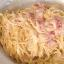
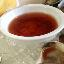
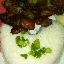
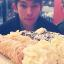
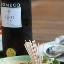
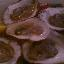
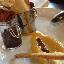
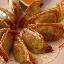
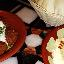
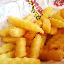

In [0]:
# Display sample records with images
# Option 1: Simple table view with metadata (recommended for quick inspection)
print("Sample records from table:")
display(
    spark.table(FULL_TABLE_NAME)
        .select("split", "label_id", "label")
        .limit(10)
)

# Option 2: Display actual images using displayHTML
print("\nSample images from the table:")
import base64

sample_data = spark.table(FULL_TABLE_NAME).limit(10).collect()

html = "<div style='display: grid; grid-template-columns: repeat(4, 1fr); gap: 15px;'>"
for row in sample_data:
    img_base64 = base64.b64encode(row['image_bytes']).decode()
    html += f"""
    <div style='text-align:center; padding:10px; border: 1px solid #ddd;'>
        <img src='data:image/jpeg;base64,{img_base64}' style='max-width:150px; height:auto;'><br>
        <b>{row['label']}</b><br>
        <small>Split: {row['split']} | ID: {row['label_id']}</small>
    </div>
    """
html += "</div>"
displayHTML(html)


Diverse sample - one image from each food category:


apple_pie ID: 0,baby_back_ribs ID: 1,baklava ID: 2,beef_carpaccio ID: 3
beef_tartare ID: 4,beet_salad ID: 5,beignets ID: 6,bibimbap ID: 7
bread_pudding ID: 8,breakfast_burrito ID: 9,bruschetta ID: 10,caesar_salad ID: 11

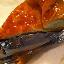
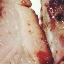
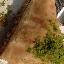
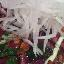
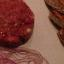
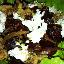
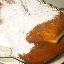
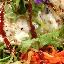
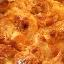
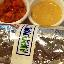
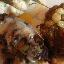
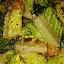

In [0]:
# Display diverse sample (one image from each of first 12 food categories)
from pyspark.sql import functions as F

print("Diverse sample - one image from each food category:")

# Get one image per category
diverse_data = (spark.table(FULL_TABLE_NAME)
    .groupBy("label_id", "label")
    .agg(F.first("image_bytes").alias("image_bytes"))
    .orderBy("label_id")
    .limit(12)
    .collect())

# Create HTML grid
html = "<table style='width:100%'><tr>"
for idx, row in enumerate(diverse_data):
    img_base64 = base64.b64encode(row['image_bytes']).decode()
    
    html += f"""
    <td style='text-align:center; padding:10px;'>
        <img src='data:image/jpeg;base64,{img_base64}' width='150'><br>
        <b>{row['label']}</b><br>
        <small>ID: {row['label_id']}</small>
    </td>
    """
    
    if (idx + 1) % 4 == 0:
        html += "</tr><tr>"

html += "</tr></table>"
displayHTML(html)


## Summary

✓ Successfully loaded Food101 images from h5 files  
✓ Created Delta table with proper schema  
✓ Data is ready for downstream processing and model training  

**Next Steps:**
- Use this bronze table for exploratory data analysis
- Create silver/gold tables with additional transformations
- Train conformal prediction models on the labeled data
